In [1]:
library(tidyverse)
library(tidymodels)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
cbb <- read_csv("https://raw.githubusercontent.com/naw333/College-Basketball-Data-Science/main/cbb.csv")
head(cbb,n=3)

Rows: 3523 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): TEAM, CONF, POSTSEASON, SEED
dbl (20): G, W, ADJOE, ADJDE, BARTHAG, EFG_O, EFG_D, TOR, TORD, ORB, DRB, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,⋯,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,⋯,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1,2016
Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,⋯,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1,2015
Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,⋯,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3,2018


In [3]:
cbb_playoff <- cbb |>
    filter(POSTSEASON != "N/A" & POSTSEASON != "R68") |>
    mutate(RESULT64 = ifelse(POSTSEASON == "R64", "Loss", "Win")) |>
    mutate(RESULT32 = ifelse(POSTSEASON == "R32" | POSTSEASON == "R64", "Loss", "Win"))
head(cbb_playoff)

TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,⋯,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,RESULT64,RESULT32
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,⋯,44.6,32.7,36.2,71.7,8.6,2ND,1,2016,Win,Win
Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,⋯,44.7,36.5,37.5,59.3,11.3,2ND,1,2015,Win,Win
Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,⋯,46.8,35.2,33.2,65.9,6.9,2ND,3,2018,Win,Win
Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,⋯,41.9,36.5,29.7,67.5,7.0,2ND,3,2019,Win,Win
Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,⋯,40.0,38.2,29.0,71.5,7.7,2ND,1,2017,Win,Win
Kentucky,SEC,40,29,117.2,96.2,0.9062,49.9,46.0,18.1,⋯,44.9,33.2,32.2,65.9,3.9,2ND,8,2014,Win,Win


<font size="5">**Preliminary Data Visualization**<font>

Redundant Variable Filtering

Our dataset contains some variables that are either redundant or not relevant to the purpose of our research question. Filtering these out now has the added benefit of making our data visualization and variable selection later both more comprehensible and easier for the notebook to run. We will explain our reasoning for each variable removed here briefly.

TEAM, CONF, YEAR (College team, conference, year) - None of these are relevant to our research question. The conference a team plays in during the regular season can be an indicator of its strength of schedule. The BARTHAG variable in our dataset already incorporates strength of schedule.

G, W, WAB (Games played, games won, how close a team is to not making the tournament) - A regular season win or loss is not relevant to our model. Furthermore, this is often an insufficient indicator of team strength because schedules vary wildly between college basketball teams.

2P_O, 2P_D, 3P_O, 3P_D, ADJ_T (2 and 3 point shooting and defense, tempo) - Itemizing 2-pointers and 3-pointers in this way carries no benefits for our model. These stats are typically referenced to highlight team strategy rather than team strength. We want to avoid variables such as this because we run the risk of overfitting to old data and making a model that is inflexible to new data. EFG_O and EFG_D effectively combine these variables already.

FTRD, TORD (opposing free throw rate, steal rate) - These are fringe stats that, from a basketball analysis perspective, are poor indicators of what they are meant to evaluate. A defense that doesn't foul much or steals the ball a lot is not a good defense but is playing against a bad offense. Interestingly, the reverse of these (free throw and turnover rate) are thought of as excellent indicators of an offense's consistency.

<font size="4">**Density Plot - Comparative strength of teams eliminated in the first three rounds of March Madness**<font>

We want to compare teams that are elminated in the first round of the tournament with teams that are eliminated in the second round and so on for each round in order to find variables capable of distinguishing the advantages held by winning teams. We use a series of density plots to visualize these relationships. A quality variable for the model should show distinct peaks in each succsesive round of the tournament. Only the first three rounds are included in the graph below because the graphs become visually cluttered with all 6 rounds included. Additionally, it is difficult to interpret a density plot of the last few rounds of the tournament because of the diminishing sample size of teams eliminated in each round.

Note: The following statistics should be interpreted as a lower value indicating stronger performance: ADJDE, DRB, EFG_D, and TOR. All of these stats evaluate the scoring of opposing teams in some way, except for TOR, which evaluates turnover rate of an offense.

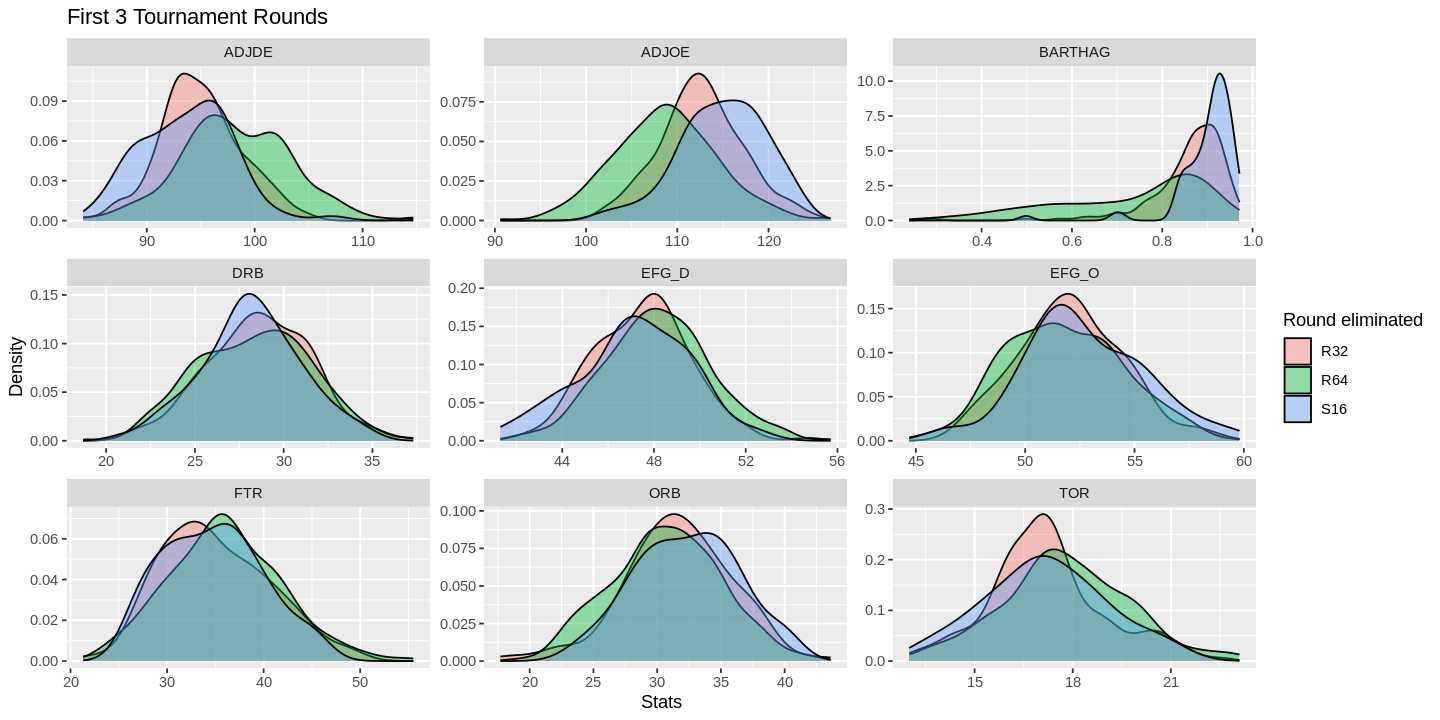

In [17]:
options(repr.plot.height = 6, repr.plot.width = 12)

## Make a subset that contains the variables we want. The data is filtered to only include teams eliminated in the first three rounds for visual clarity while maintaining a high sample size.
cbb_f3 <- cbb_playoff |>
    select(ADJDE, ADJOE, EFG_O, TOR, BARTHAG, ORB, DRB, FTR, EFG_D, POSTSEASON) |>
    filter(POSTSEASON == "R64" | POSTSEASON == "R32" | POSTSEASON == "S16")

## Density plot.
cbb_f3 |>
    pivot_longer(cols = -POSTSEASON, names_to = "category", values_to = "value") |>
ggplot(aes(x = value, fill = POSTSEASON)) +
    geom_density(alpha = 0.4) +
    facet_wrap(facets = vars(category), scales = "free") +
    labs(title = "First 3 Tournament Rounds", x = "Stats", y = "Density", fill = "Round eliminated")

ADJDE, ADJOE, and BARTHAG show the greatest distinction between each round. The first three of these are 'adjusted' to assume each team is playing against an average NCAA basketball team. For example, ADJDE estimates the amount of points an average NCAA offense would score against the team in question. Of the remaining, most seem to establish a slight, if insignificant, positive trend between successive rounds. TOR, for instance, seems to show a positive trend from the round of 64 to 32, but not the same improvement from 32 to 16. FTR, interestingly, seems to suggest an inverse trend. Teams eliminated in the round of 64 tend to have higher free throw rates than teams eliminated later in the tournament.

<font size="4">**Density Plot - Comparative strength of 4, 8, and 12 seeds in March Madness**<font>

As previously discussed, the task of our model is to seed March Madness more accurately than the NCAA. The density plots below are derived from where teams are seeded by the NCAA before playing any playoff games. The format is meant to mirror the plots above for comparison between the two sets. This comparison may reveal predictors that are undervalued in the current seeding process. Implementing these predictors in our own analysis could give our model an edge in predicting 'upsets' in the tournament.

The seeds chosen are not arbitrary. While there are no similar sample size concerns as above (there are four teams with a 1 seed, four with a 2 seed and so on), choosing the 4, 8, and 12 seeds here mirrors the format above. A 12 seed, for instance, is an 'underdog' in the first round as they play against a 5 seed. An 8 seed is favored against a 9 seed in the first round, but likely has to play a 1 seed in the 2nd round. A 4 seed is favored up until the third round if the rest of the bracket unfolds as expected.

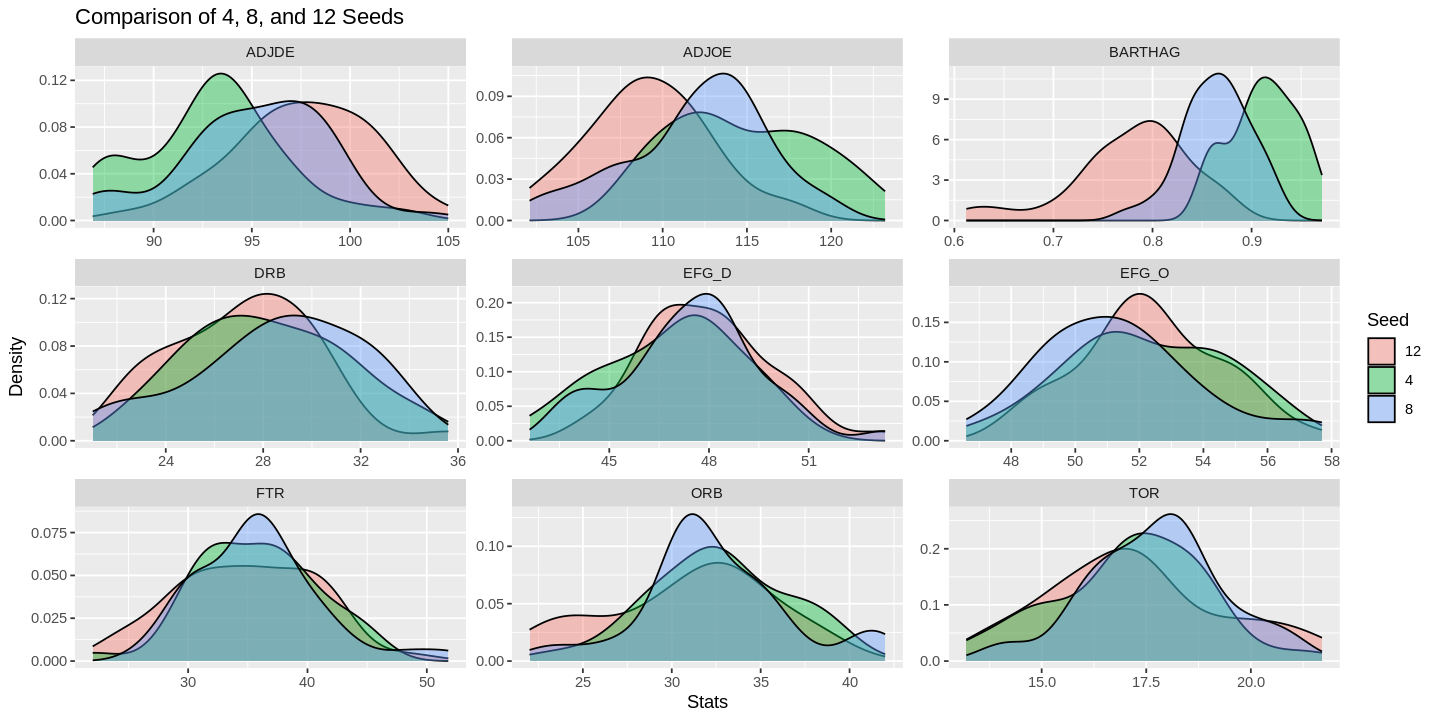

In [23]:
options(repr.plot.height = 6, repr.plot.width = 12)

## Make a subset that contains the variables we want. The data is filtered to only include teams seeded 4, 8, and 12.
cbb_seed <- cbb_playoff |>
    select(ADJOE, ADJDE, EFG_O, TOR, BARTHAG, ORB, DRB, FTR, EFG_D, SEED) |>
    filter(SEED == "4" | SEED == "8" | SEED == "12")

## Density plot.
cbb_seed |>
    pivot_longer(cols = -SEED, names_to = "category", values_to = "value") |>
ggplot(aes(x = value, fill = SEED)) +
    geom_density(alpha = 0.4) +
    facet_wrap(facets = vars(category), scales = "free") +
    labs(title = "Comparison of 4, 8, and 12 Seeds", x = "Stats", y = "Density", fill = "Seed")

ADJDE, ADJOE, and BARTHAG again seem to most decisively separate these groups of teams. Generally, a wider distribution of densities is observed across all variables. One interesting point is the density distributions of 4 seeds have multiple peaks for many of these stats. This would imply there are some 4 seeds that are markedly better than their peers. If these teams outperform higher seeded teams in the NCAA tournament, our model should be able to identify these teams and rank them higher than the seed they were given.